In [ ]:
#Sound Samples
#http://www.philharmonia.co.uk/explore/sound_samples/bass_clarinet?p=2

import numpy as np
from scipy import signal
import scipy.io.wavfile as sp
import os

#class that represents an instrument playing a specific note and its segments
class Instrument:
    def __init__(self, name, data, rate, segments):
        self.name = name             # instrument name
        self.data = data             # raw waves for the audio
        self.rate = rate             # sampling rate for the audio
        self.segments = segments     # segmented waves after fourier transform
        
#dictionary of the instruments
instruments = []
        
#iterate through all instrument folders in wav_data
directory = "data/wav_data/"
for folder in os.listdir(directory):
    if "." not in folder:
        #create an instrument object with the appropriate name per folder
        new_instrument = Instrument(folder, [], [], [])
        #iterate through all .wav files in folders
        for file_path in os.listdir(directory + folder):
            if file_path.endswith(".wav"):
                #rate = frames per second, data = the frames
                rate, data = sp.read(directory + folder + "/" + file_path)
                #append the data and rate for the sample
                new_instrument.data.append(data)
                new_instrument.rate.append(rate)
        #add instrument to instruments list
        instruments.append(new_instrument)   
        #print that new instrument was added
        print(new_instrument.name, 'added')

#find mean volume of sound samples 
lists_of_tops = [[np.max(sample) for sample in instrument.data] for instrument in instruments]
list_of_tops = [top for list_of_tops in lists_of_tops for top in list_of_tops]
mean_volume = np.mean(list_of_tops)  

#scale the volume for all the audio samples
def scale_volume(data, avg_volume = mean_volume):
#     result = []
#     for d in data:
#         scale = max(-1 * min(data), max(data))
#         d = d * avg_volume/scale
#         result.append(d)
#     return result
    final_scale = avg_volume / (max(-1 * min(data), max(data)))
    return data * final_scale

#scale the data and perform stft
for instrument in instruments:
    #rescale data
    for i in range(0, len(instrument.data)):
        instrument.data[i] = scale_volume(instrument.data[i])

        #get the data and rate
        data = instrument.data[i]
        rate = instrument.rate[i]

        #duration = number of frames / frames per second
        duration = len(data) / rate

        #overlap = frames per 10ms
        overlap = rate/1000*10
        overlap = int(overlap)

        #window_size = frames per 25ms
        window_size = rate/1000*25
        window_size = int(window_size)
        '''
        #extract frame segments with overlaps
        f, t, Zxx = signal.stft(data, window = 'hann', nperseg = window_size, noverlap = overlap)

        #log of the absolute values of each segment
        Zxx = abs(Zxx)
        Zxx = [[np.log10(d) if d != 0 else 0 for d in segment] for segment in Zxx]
        
        #add the stft result to the instrument
        instrument.segments.append(Zxx)
        '''
    print("FINISHED " + instrument.name)

snare_drum added
cello added
banjo added
violin added
french_horn added
trombone added
oboe added
bass_clarinet added
trumpet added
guitar added
triangle added
bass_drum added
saxophone added
tambourine added
tuba added
cowbell added
viola added
flute added
clash_cymbals added
double_bass added
FINISHED snare_drum
FINISHED cello
FINISHED banjo
FINISHED violin
FINISHED french_horn


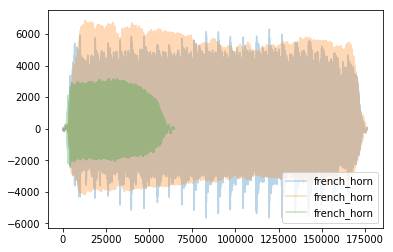

In [17]:
import matplotlib.pyplot as plt

instrument = instruments[0]
for data in instrument.data:
    plt.plot(data, label=instrument.name, alpha=0.3)
plt.legend()
plt.show()

In [ ]:
# when seeing new test data, we sample it at the same rate and then average its scores on all k-means regressions

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html
    
# https://kevinsprojects.wordpress.com/2014/12/13/short-time-fourier-transform-using-python-and-numpy/

In [ ]:
from sklearn.cluster import KMeans

# Data
X = np.array([[1, 2], [1, 4], [1, 0],
              [4, 2], [4, 4], [4, 0]])

# Clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
# kmeans.labels_ = [0, 0, 0, 1, 1, 1]

# Predict labels
kmeans.predict([[0, 0], [4, 4]]) # [0, 1]

# Return Centers
kmeans.cluster_centers_

In [81]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 221, random_state = 0).fit(instruments[0].segments)